# Data Driven Building Energy Management - Final Project
### Analysis of Energy Consumption of Academic & Administrative Buildings at Carnegie Mellon
### Joseph Dryer - jdryer@andrew.cmu.edu

## Introduction
The ipython notebook to follow contains the data analysis and more elaborate discussion of intermittent methods and results for my project on the Analysis of Building Energy Consumption at Carnegie Mellon University. Exploratory data analysis allows me to identify the buildings in the data provided (see Data Source), their use and size, and thus to narrow down a few buildings to analyze. Further EDA leads me to select three buildings to continue analysis on - Roberts Engineering Hall, Scaife Hall, and Warner Hall. An exploratory analysis on power consumption as it related to temperature and time of day, week, and year is then carried out, allowing comparison between buildings. The results help inform prediction models to be used. For each building a multivariate linear regression model is used that predicts power consumption to a reasonable degree of accuracy during business hours. This model is a modification of the model described in [Mathieu et al](http://eande.lbl.gov/sites/all/files/LBNL-4944E.pdf) such that time period of a day are considered as opposed to time periods of a week. A comparison of performance is made to the original model. Finally, based on EDA and regression results, it is decided that the model may be suited to be extended to all hours of a businessday. It's performance in this context is evaluated.

### Data Source

The data used in this analysis was supplied by Dr. Bertrand Lasternas and The Center for Building Performance and Diagnostics at Carnegie Mellon. It contains power readings at 10 minute intervals for 31 different buildings on campus from Nov. 17th 2014 to Nov 17th 2015. Also provided was temperature data at 5 minute intervals from Nov. 1st 2014 to Dec. 1st 2015. 

# Loading the Data: Power and Temperature

The first step in the analysis is to open up the data and do some exploratory data analysis. We import the modules we will need during this analysis:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import scipy.spatial.distance as dist
from scipy import stats
import random
%matplotlib inline

## Temperature Data

We load in the temperature data using the numpy genfromtxt function. A converter brings the date string into a datetime object to make accessing information on timestamps easier. The data is loaded into a structured array with field names. 

Load in temperature data. [Info](https://docs.python.org/2/library/datetime.html) on format for strptime.

In [2]:
date_converter = lambda d : dt.datetime.strptime(d,'%d-%b-%y %H:%M:%S')
temp_file='Outdoor_Temp.csv'
dtypes=[('Time', type(dt.datetime.now())),('tempF','f64')]
temps = np.genfromtxt(temp_file,delimiter=",",dtype=dtypes,\
                             converters={0: date_converter}, skip_header=True)

The temperature data may contain gaps or misreads that result in a string or non float type number being present in the *temps* array. We can check if this is the case:

In [3]:
def check(temp_array):
    for temp in temp_array:
        if np.isnan(temp)==True:
            return True
print check(temps['tempF'])

True


We see that there are 'nans' in the array and so we proceed to remove them and replace them with the average of the data points before and after their index. 

In [4]:
while check(temps['tempF'])==True:
    for i,temp in enumerate(temps['tempF']):
        if np.isnan(np.float(temp)):
            before=np.isnan(temps['tempF'][i-1])
            after=np.isnan(temps['tempF'][i+1])
            if ~before and ~after:
                temps['tempF'][i]=np.mean([temps['tempF'][(i-1)],temps['tempF'][(i+1)]])
            elif before and ~after:
                temps['tempF'][i]=np.mean([temps['tempF'][(i-2)],temps['tempF'][(i+1)]])
            elif ~before and after:
                temps['tempF'][i]=np.mean([temps['tempF'][(i-1)],temps['tempF'][(i+2)]])
            else:
                temps['tempF'][i]=np.mean([temps['tempF'][(i-2)],temps['tempF'][(i+2)]])

What is the time step of the data?

In [5]:
def time_delta(timestamps):
    time_delta=stats.mode(np.diff(timestamps),axis=None)[0][0]
    print "The timestamp resolution of the data is: %s"%str(time_delta)
time_delta(temps['Time'])

The timestamp resolution of the data is: 0:05:00


The timestamp is 5 minutes.

## Power Data
Now we load in the power data (it's just a lot more columns this time) the same way. 

In [6]:
date_converter = lambda d : dt.datetime.strptime(d,'%d-%b-%y %H:%M:%S')
data_file='Building_Energy.csv'
floats=['f8']*31
dtypes=[dt.datetime]
for item in floats:
    dtypes.append(item)
all_bld_data = np.genfromtxt(data_file,delimiter=",", names=True, dtype=dtypes,\
                      converters={0: date_converter})

What are the different column headings (building names and power units)?

In [7]:
for item in all_bld_data.dtype.names:
    print item
print len(all_bld_data.dtype.names)

Time
Baker_Hall_Electric_Real_Power_W
Boss_House_Electric_Real_Power_W
CMUSCSC_GatesThird_FloorBuilding_Electric_MeterReal_Power_kW
Cyert_Electric_Real_Power_W
Dithridge_St_Garage_Electric_Real_Power_W
Doherty_Apts_Electric_Real_Power_W
Doherty_Hall_West_Electric_Real_Power_W
Donner_Electric_Real_Power_W
ECG_Electric_Real_Power_W
FMS_Bldg_Electric_Real_Power_W
GSIA_Electric_Real_Power_W
Hamerschlag_277480_Electric_Real_Power_W
Hamerschlag_House_Electric_Real_Power_W
Henderson_House_Electric_Real_Power_W
Hunt_Library_480_MMC_Electric_Real_Power_W
McGill_House_Electric_Real_Power_W
MMCH_Electric_Real_Power_W
Mudge_House_Electric_Real_Power_Mudge
Porter_Hall_Electric_Real_Power_W
Posner_Hall_Electric_Real_Power_W
Purnell_Center_Electric_Real_Power_W
Roberts_Hall_Electric_Real_Power_W
Scaife_Hall_Electric_Real_Power_W
Scobell_House_Electric_Real_Power_W
Shirley_Apts_Electric_Real_Power_W
Skibo_Gym_Electric_Real_Power_W
Stever_House_Electric_Real_Power_W
University_Center_Electric_Real_Powe

Since one of our end goals is to compare power usage among buildings, we elect to choose buildings of similar size with similar (expected) hours and similar use.

Looking at a [map of CMU[(http://www.cmu.edu/about/visit/campus-map-interactive/), I will chose the following 5 academic / administrative buildings which are all on the small to medium size. We consider academic / administarative as similar in type, as opposed to buildings of very different use (athletic, residence, etc). We also consider size from only a rough approximation from the map, as these buildings were contrasting to much larger buildings (University Center, Wean Hall, Porter Hall all quite large, for example).

* Smith Hall
* Warner Hall
* Roberts Hall
* Scaife Hall
* Cyert Hall

Let's get the [square footage](https://fst-apps.andrew.cmu.edu/roomspec/roomspec) for these buildings so we can (later on) normalize energy consumption. 

In [8]:
sizes={'Roberts':64599.5999,'Hunt':100278.33999,\
       'Cyert':64447.149998,'Warner':45436.630017,'Scaife':36849.90000000001}

In [9]:
for name,sf in sizes.iteritems():
    print name,": %.0f"%sf, "sq ft"

Roberts : 64600 sq ft
Hunt : 100278 sq ft
Scaife : 36850 sq ft
Cyert : 64447 sq ft
Warner : 45437 sq ft


The buildings are all in the range 35-100 thousand sq ft. Let's go ahead and select a data subset based on this:

In [10]:
dtypes=[('Time', type(dt.datetime.now())),('Roberts','f8'),('Hunt','f8'),\
        ('Scaife','f8'),('Cyert','f8'),('Warner','f8')]
power_data_5=zip(all_bld_data['Time'],all_bld_data['Roberts_Hall_Electric_Real_Power_W'],\
                all_bld_data['Hunt_Library_480_MMC_Electric_Real_Power_W'],\
               all_bld_data['Scaife_Hall_Electric_Real_Power_W'],\
                 all_bld_data['Cyert_Electric_Real_Power_W'], \
                all_bld_data['Warner_Hall_Electric_Real_Power_W'])
power_data_5=np.array(power_data_5,dtype=dtypes)


What is the time-step resolution?


In [11]:
time_delta(power_data_5['Time'])

The timestamp resolution of the data is: 0:10:00


## Combining Temperature and Power Data

We will use the power (energy) data timescale and interpolate the temperature to this. So for regression we will use 10 min time of weeks since this is the spacing of time in the power data. Interpolation function below is recycled from Professor Berges's [assignment 2 starter file](https://github.com/marioberges/courses_12-752/blob/master/assignments/2/12-752_Assignment_2_Starter.ipynb). Basically, we are taking the temperature data and creating a line between every data point. Then we use those lines to get temperature values for every timestamp in the power data. 

In [12]:
def power_interp(tT, T, tP):
    toposix = lambda d: (d - dt.datetime(1970,1,1,0,0,0)).total_seconds()
    tP = map(toposix, tP)
    tT = map(toposix, tT)
    from scipy.interpolate import interp1d
    f = interp1d(tT, T,'linear')
    return f(tP)
temps_array=power_interp(temps['Time'],temps['tempF'],power_data_5['Time'])

Now we just combine power and temperature to get a single data structure where we can access any information we need.

In [13]:
data=zip(power_data_5['Time'],temps_array,power_data_5['Roberts'],\
         power_data_5['Hunt'],power_data_5['Scaife'],power_data_5['Cyert'],power_data_5['Warner'])
dtypes=[('Time', type(dt.datetime.now())),('Temp','f8'),('Roberts','f8'),('Hunt','f8'),\
        ('Scaife','f8'),('Cyert','f8'),('Warner','f8')]
data=np.array(data,dtype=dtypes)

### Removing Nans

Just as for temperature, we must remove any Nans in the power data. While we will do our data analysis such that gaps or order don't matter, we do need to make sure all data is a real number. 

In [14]:
def RemoveNans(data):
    not_nans=[]
    for i,row in enumerate(data):
        not_nan=True
        for num in list(row)[1:]:
            if np.isnan(num):
                not_nan=False
        not_nans.append(not_nan)
    data=np.take(data,np.where(not_nans)[0])
    return data
data=RemoveNans(data)

## Normalizing to Get EUI

With buildings of different size, to compare energy usage we decide to use energy use intensity. In this case, the quantity is power intensity or power per sq. ft. building area. 

In [15]:
def EUI_FromPower(data,buildings,sizes):
    # buildings should be a list of building names
    for building in buildings:
        for i,num in enumerate(data[building]):
            data[building][i]=num/sizes[building]
    return data
data=EUI_FromPower(data,['Roberts','Scaife','Warner'],sizes)

## Exploratory Data Analysis

With our data loaded and cleaned, we are ready to do some exploratory data analysis. 

Questions to answer:

* Does power consumption vary with temperature? Is this relationship linear? Could a piecewise function be applied to descripe it?
* Would a 'time of day' instead of 'time of week' model be appropriate for these buildings?
* Should we look at all 5 buildings, or a subset of those?

To make things easy, let's make a function that plots out the things we care about for exploratory data analysis for a particular building:

In [74]:
def EDA1(data,building):
    times=[]
    for time in data['Time']:
        times.append(str(time))
    fig=plt.figure(figsize=(16,10))
    ax1=plt.subplot2grid((8,8),(0,0),colspan=7,rowspan=3)
    p=plt.plot(data['Time'],data[building],'b.')
    plt.xlabel('Time')
    plt.xticks(rotation=70)
    plt.ylabel('Power Intensity [W/ft^2]')
    
    ax3=plt.subplot2grid((8,8),(4,0),colspan=3,rowspan=3)
    plt.plot(data['Time'][20000:20300],data[building][20000:20300],'.')
    plt.xlabel('Time');
    plt.xticks(rotation=70)
    plt.ylabel('Power Intensity [W/ft^2]');
    
    ax3=plt.subplot2grid((8,8),(4,4),colspan=3,rowspan=3)
    plt.plot(data['Time'][20000:21000],data[building][20000:21000],'.')
    plt.xlabel('Time');
    plt.xticks(rotation=70)
    plt.ylabel('Power Intensity [W/ft^2]');

    fig=plt.figure(figsize=(5,3));
    plot=plt.boxplot([[data[building][np.where(np.array([t.hour for \
                        t in data['Time']])==i)[0]]] for i in range(24)]);
    plt.ylabel('Power Intensity [W/ft^2]');
    plt.xlabel("Hour of the Day");

### Roberts

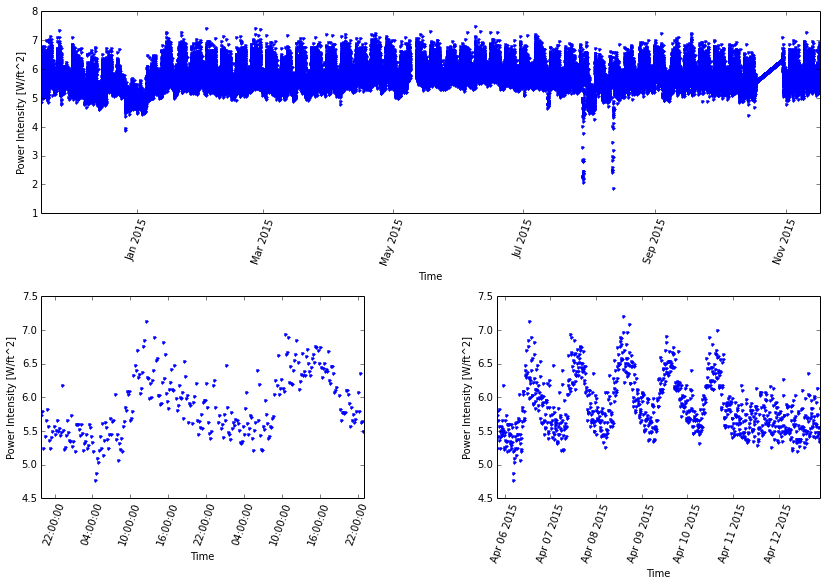

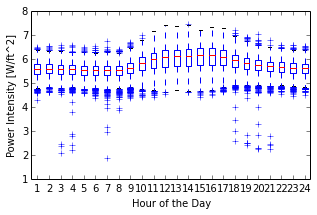

In [75]:
EDA1(data,'Roberts')

### Scaife

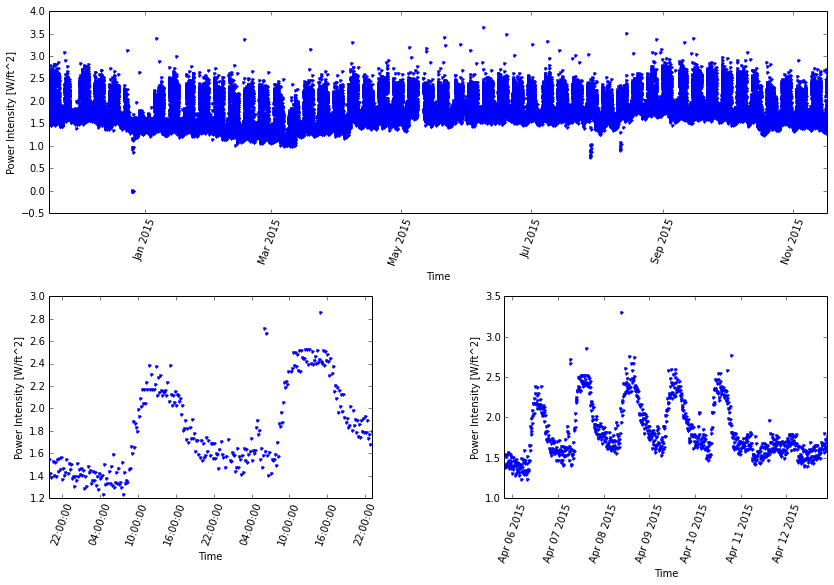

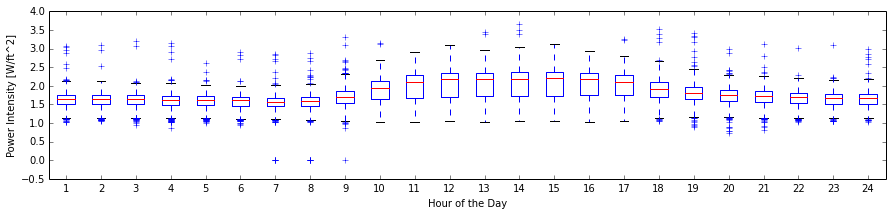

In [18]:
EDA1(data,'Scaife')

### Warner


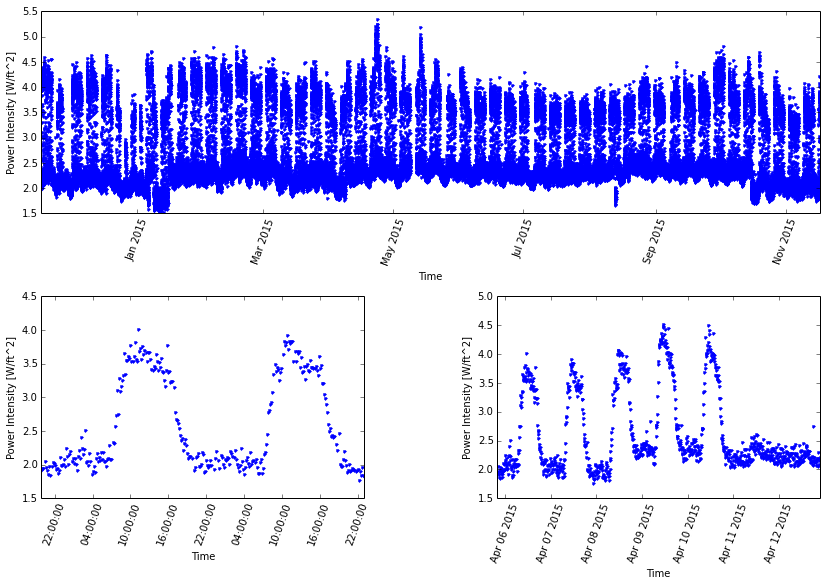

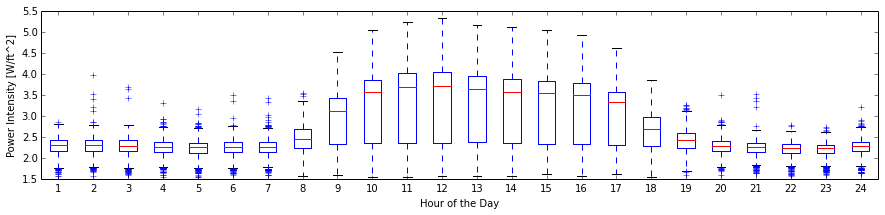

In [19]:
EDA1(data,'Warner')

### Cyert

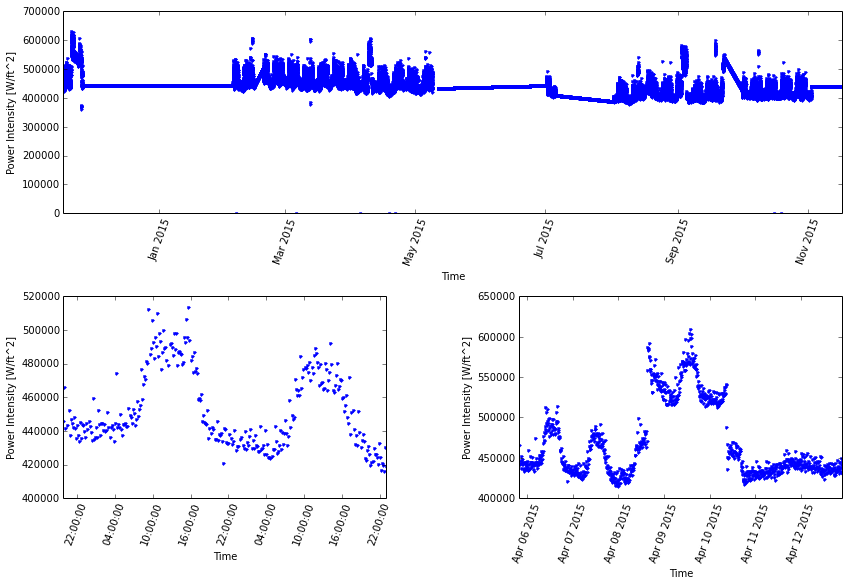

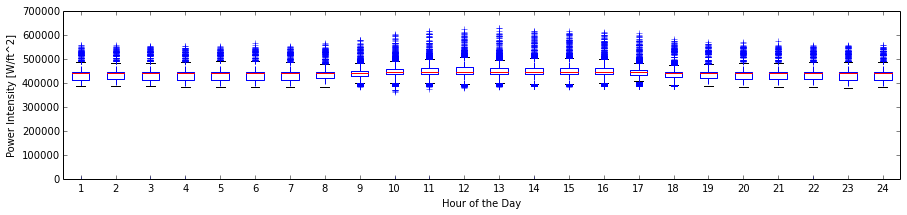

In [20]:
EDA1(data,'Cyert')

### Hunt

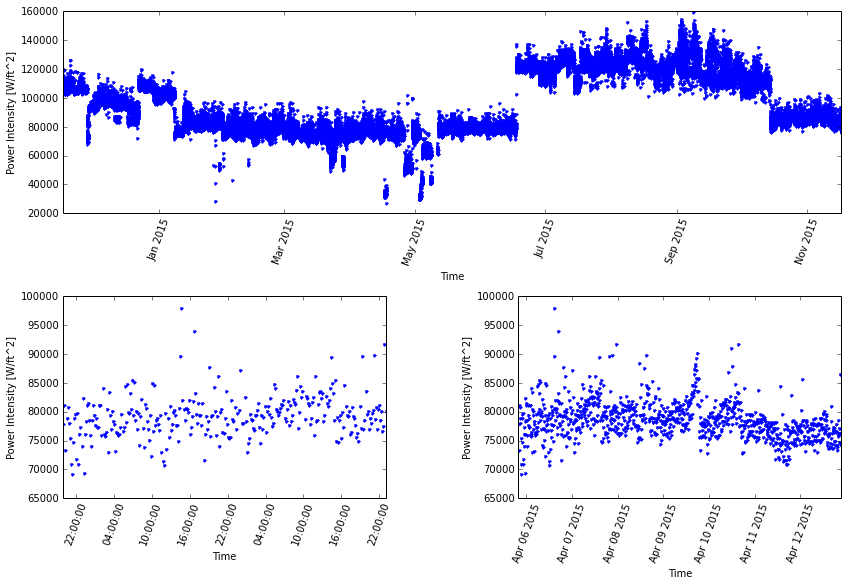

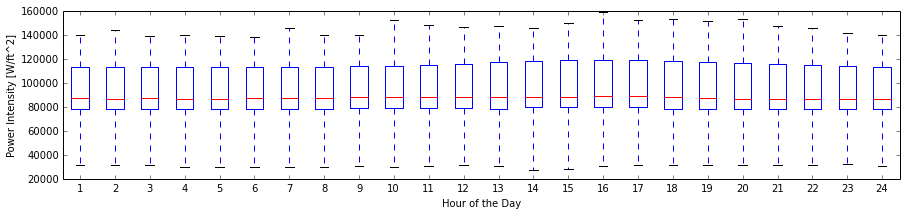

In [21]:
EDA1(data,'Hunt')

## Conclusions:

Should we use a subset of this data?
* The first three buildings are best in terms of quality of data for one whole year
* The last two buildings have large data gaps (Cyert) or else data that seems to have significant errors (Hunt)
* We will look at only the first three. We consider only these three from here on.

Does power intensity depend on time of day? Time of week?
* Power intensity depends on time of day clearly
* This daily pattern is generally maintained during a week, so we will explore using a time of day indicator will be used instead of a time of week indicator.

Comparing Range of Magnitude of Power Intensity:
* Roberts has the highest power intensity, ranging frinsteadom 5-7 W/ft^2
* Scaife has the lowest intensity of 1.5-3 W/ft^2 (smallest range)
* Warner has an intensity of 2-4.5 W/ft^2 (largest range)

## Taking a Data Subset: Occupied Hours of Weekdays

Judging by the power vs time of day plots, 9 AM to 5 PM should be a good time range for the peak power usage associated with the business day schedule. At this point we are considering a subset in preparation for the linear regression models to be constructed which require that either occupied or unoccoupied states of the buidlings be present.

In [22]:
weekdays=[0,1,2,3,4]
workhours=[9,10,11,12,13,14,15,16]
time_days =map(lambda timestamp: timestamp.weekday(), data['Time']) 
time_hours=map(lambda timestamp: timestamp.hour,data['Time'])
weekday_indices=np.where(np.in1d(time_days,weekdays))[0]
hour_indices=np.where(np.in1d(time_hours,workhours))[0]
data_bzhrs=np.take(data,np.intersect1d(weekday_indices,hour_indices))

## EDA on Weekday Subset

Let's see if there's a relationship between power use intensity and temperature. First, a function to make the plots:

In [23]:
def EDA2(data,building):
    times=[]
    for time in data['Time']:
        times.append(str(time))
    fig=plt.figure(figsize=(16,10))
    ax1=plt.subplot2grid((8,8),(0,0),colspan=7,rowspan=3)
    plt.plot(data['Temp'],data[building],'.')
    plt.xlabel('Temperature [F]');
    plt.xticks(rotation=70)
    plt.ylabel('Power Intensity [W/ft^2]');

### Roberts

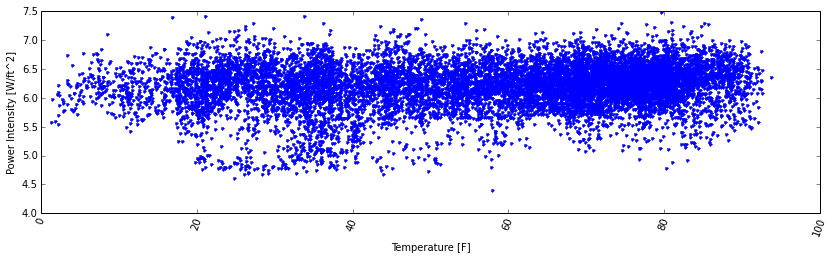

In [24]:
EDA2(data_bzhrs,'Roberts')

### Scaife

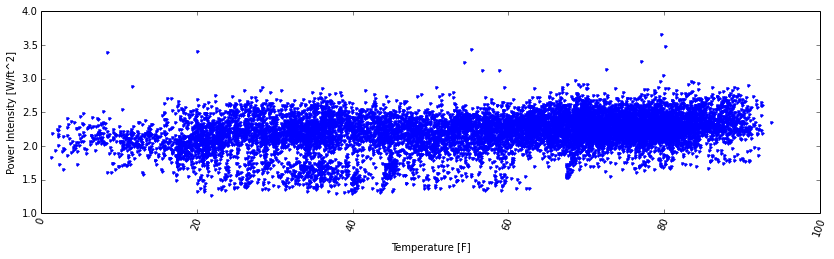

In [25]:
EDA2(data_bzhrs,'Scaife')

### Warner

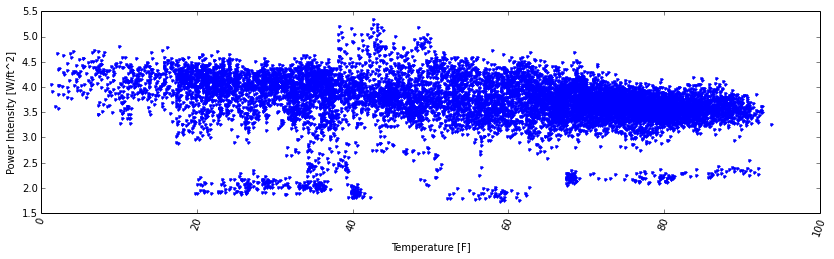

In [26]:
EDA2(data_bzhrs,'Warner')

### Conclusions

Does electricity consumption depend on temperature?
* No clear relationship between temperature and power intensity 
* Scaife and Roberts may show a slight increase in power intensity with temperature
* Warner may show a slight decrease in power intensity with temperature 
* We will include temperature in the model as a piece wise function. Since there are not clear inflection points, we will use 10 F bins as done in Mathieu et al. 

# Quantitative Comparisons

We now examine statistical properties of the data for the three buildings of interest in order to learn about power comparison and how it compares among the three. We define a function that produces the mean, median, and standard deviation of the data set for each. 

In [27]:
def Stats(data,building):
    mean=np.mean(data[building])
    median=np.median(data[building])
    std=np.std(data[building])
    return (mean,median,std)
stats_Roberts=Stats(data_bzhrs,'Roberts')
stats_Scaife=Stats(data_bzhrs,'Scaife')
stats_Warner=Stats(data_bzhrs,'Warner')
from tabulate import tabulate
print "                  Power Intensity [W/ft^2]"
print "            ---------------------------------------"
print tabulate([['Roberts',stats_Roberts[0],stats_Roberts[1],stats_Roberts[2]],\
               ['Scaife',stats_Scaife[0],stats_Scaife[1],stats_Scaife[2]],\
              ['Warner',stats_Warner[0],stats_Warner[1],stats_Warner[2]]],\
              headers=['Building','Mean','Median','Standard Deviation'],floatfmt=".2f")

                  Power Intensity [W/ft^2]
            ---------------------------------------
Building      Mean    Median    Standard Deviation
----------  ------  --------  --------------------
Roberts       6.21      6.24                  0.38
Scaife        2.21      2.24                  0.26
Warner        3.71      3.73                  0.48


Roberts uses the most per square foot, on average. Scaife uses the least, while Warner is in between. Warner also shows the largest variable in power usage, while Scaife shows the least. Roberts Engineering hall has a variety of different research labs for the Chemical Engineering, Electrical Engineering and Computer Science, and Materials Engineering departments. Scaife Hall is mostly lecture classrooms and offices, with a few research laboratories. Warner is staff and admistration offices and facilities. Based on this, the results for power usage intensity make sense. We originally grouped together administrative and academic buildings into a single category, but after performing the analysis we see that an engineering building with research labs can use nearly three times that of an administrative building or classroom based building. Considering this, any comparison of power intensity response to temperature change should focus on Scaife and Warner. 

# Multivariate, Linear Regression

In this section we will setting up a regression model.
Building energy consumption can be predicted by regression analysis on temperature, time, and power consumption data. One such regression model is the 'piecewise linear and continuous temperature-dependent load model' described in Mathieu et al:

$$L_o(t_i,T(t_i))=\alpha_i + \sum_{j=1}^{j} \beta_jT_{c,j}(t_i)$$

This model splits a characteristic time of week period (for example, weekdays during business hours) into $i$ time intervals with regression coefficients $\alpha_i$ and into $j$ temperature ranges with regression coefficients $\beta_j$.

We apply this model in this form as well as using daily instead of weekly time blocks. This is done in the building of the design matrix which is the only difference between the two models when applied. Since the building energy data is at 10 minute intervals, we used 6 ten minute intervals per hour for each of the 8 working hours per day, or 10 minute intervals of business hours in a week for the original model. In matrix form, the model appears as

$$y=X\beta+\epsilon$$

where $y$ is the load vector (power intensity in this case), $X$ is the design matrix, and $\beta$ is the vector of regression coefficients. $\epsilon$ is the error vector quantifiying the difference between predicted and actual.


$$
\begin{bmatrix}
    1       & 0      & 0      & \dots  & 0        &  T_{c,j=1}(t_{i=0}) & \dots &T_{c,j=k}(t_{i=0}) \\
    0       & 1      & 0      & \dots  & 0         & \vdots & \vdots & \vdots  \\
    \vdots  & \vdots & \vdots & \vdots & 0        & \vdots  & \vdots & \vdots \\
    0       & 0      & 0      & \dots  & 1         & T_{c,j=1}(t_{i=i}) & \dots &T_{c,j=k}(t_{i=i}) 
\end{bmatrix}
\begin{bmatrix}
    \alpha_{i=1}   \\
    \vdots       \\
    \alpha_{i=i} \\
    \beta_{j=1}\\
    \vdots\\
    \beta_{j=k}
\end{bmatrix}
=
\begin{bmatrix}
    y_{i=0}   \\
    y_{i+1}      \\
    \vdots\\
    y_{i=i} 
\end{bmatrix}
$$

Note that this matrix is repeated as the daily or weekly time period occurs many times in the data set. 

## Building the Model

First we define functions that will take a temperature and chop it up into temperature bins, filling each completely or partially depending on the temperature. 

In [28]:
def create_bounds(temp_values,bin_size):
    # create temperature bounds based on a bin size and temperature range
    lower=min(temp_values)-min(temp_values)%bin_size+bin_size
    upper=max(temp_values)-min(temp_values)%bin_size+bin_size
    bounds=[lower]*(((upper-lower)/bin_size)+1)
    for i,item in enumerate(bounds):
        bounds[i]=item+bin_size*i
    bounds=tuple(bounds)
    return bounds

In [29]:
def Tc(temps,bounds):
    # split temperature into the appropriate bins as determined by bounds
    Tc_matrix=[]
    for temp in temps:
        row=[0]*len(bounds)
        for i,bound in enumerate(bounds):
            if temp<bound:
                row[i]=max(temp-(bound-10),0)
            elif temp>bound:
                row[i]=10
        Tc_matrix.append(row)
    Tc_matrix=np.array(Tc_matrix)
    return Tc_matrix

## Design Matrix Creation

Now we create the design matrix, which includes the temperature coefficients for each 'bin' or range of temperature, as well as the $\alpha$ coefficients for the times of week or times of day. 

In [30]:
### 10 MINUTE DAILY VERSION
def DesignMatrix_day(data_subset):
    bounds=create_bounds(data_subset['Temp'],10)
    temps=data_subset['Temp']
    Tc_matrix=Tc(temps,bounds)
    rows=[]
    for i,time in enumerate(data_subset['Time']):
        minute=time.minute
        hour=time.hour
        row=[0]*(8*6)
        index=((hour-9)*6+minute/10)
        row[index]=1
        row=row+list(Tc_matrix[i])
        rows.append(row)
    # now we return that (as a matrix)
    return np.matrix(rows)

In [31]:
### 10 MINUTE WEEKLY VERSION
def DesignMatrix_week(data_subset):
    bounds=create_bounds(data_subset['Temp'],10)
    temps=data_subset['Temp']
    Tc_matrix=Tc(temps,bounds)
    rows=[]
    for i,time in enumerate(data_subset['Time']):
        minute=time.minute
        hour=time.hour
        day=time.weekday()
        row=[0]*(8*6*5)
        index=(day*8*6+(hour-9)*6+minute/10)
        row[index]=1
        row=row+list(Tc_matrix[i])
        rows.append(row)
    # now we return that (as a matrix)
    return np.matrix(rows)


Now that a function that will create the design matrix is specified, and the loads are known, we can create a function that solves for the regression coefficients using the design matrix and power intensity values:

We now want to find the vector $\beta$ that minimizes the difference between predicted load $X\beta$ and actual load $y$ (ie the error vector $\epsilon$. 

$${|| X\beta-y ||}^2$$

The solution to this problem is then:

$$\hat\beta=(X^TX)^{-1}X^Ty$$

The function below does precisely that. 

In [32]:
def beta_hat(X,Y):
    beta_hat=np.dot(np.dot(np.linalg.inv(X.T*X),X.T),Y)
    beta_hat=np.transpose(beta_hat)
    return beta_hat

With the model set up, we can move on to train it. 

## Training the Model

We start by splitting the data into a subset for training and a subset for testing. We do this randomly: first we come up with as many random index numbers as there are data points, then we divided this by two for two equal halves. We pull the data points at those indices to produce two subsets. While usually subsets are taken as some continuous portion of time, this alternative method enables us to get the full range of temperature data in the model for training. Additionally, since the only criteria are time of day/week and temperature, there shouldn't be any case where we are predicting based on coefficients trained on the data we test on. That is, this should still be a genuine test of the model. 

In [33]:
def SplitData(data):
    random_indices=random.sample(xrange(0,len(data)),len(data))
    train_indices=random_indices[:len(random_indices)/2]
    test_indices=random_indices[len(random_indices)/2:]
    data_train=np.take(data,train_indices)
    data_test=np.take(data,test_indices[:-3300])
    return (np.sort(data_train,order='Time'),np.sort(data_test,order='Time'))
data_train=SplitData(data_bzhrs)[0]
data_test=SplitData(data_bzhrs)[1]

With that, we run our model on the training data. We make a distinction between day and week models. We produce the design matrices and $\hat\beta$ coefficients below.

In [34]:
X_train_day=DesignMatrix_day(data_train)
X_train_week=DesignMatrix_week(data_train)
X_test_day=DesignMatrix_day(data_test)
X_test_week=DesignMatrix_week(data_test)
Bh_Roberts_day=beta_hat(X_train_day,data_train['Roberts'])
Bh_Roberts_week=beta_hat(X_train_week,data_train['Roberts'])
Bh_Scaife_day=beta_hat(X_train_day,data_train['Scaife'])
Bh_Scaife_week=beta_hat(X_train_week,data_train['Scaife'])
Bh_Warner_day=beta_hat(X_train_day,data_train['Warner'])
Bh_Warner_week=beta_hat(X_train_week,data_train['Warner'])

# Evaluating the Model

Now we compare predicted power intensity to actual power intensity. First, we put the predicted data and actual data into appropriate arrays. Then, we compare results graphically. Lastly, we do a quantitative analysis that include confidence intervals and probability values on coefficients. 

In [35]:
# generate predicted power usage
predicted_Roberts_day=np.dot(X_test_day,Bh_Roberts_day)
predicted_Scaife_day=np.dot(X_test_day,Bh_Scaife_day)
predicted_Warner_day=np.dot(X_test_day,Bh_Warner_day)
predicted_Roberts_week=np.dot(X_test_week,Bh_Roberts_week)
predicted_Scaife_week=np.dot(X_test_week,Bh_Scaife_week)
predicted_Warner_week=np.dot(X_test_week,Bh_Warner_week)
# get actual power usage
actual_Roberts=data_test['Roberts']
actual_Scaife=data_test['Scaife']
actual_Warner=data_test['Warner']
time=data_test['Time']

### Evaluating Results Graphically

To do this we make a function that can be called for each building and outputs that results that we are interested in graphically. This will include an overlay of actual and predicted data on a full time scale (scatter plots of data) as well as an overlay on a daily timescale (box plots showing only IQR and median). We want to compare the accuracy of the two models as well as note differences between the buildings. 

In [62]:
# function for plotting results and graphical evaluation of model
def graph_test(actual,predicted,model_name,time,temps):
    fig=plt.figure(figsize=(15,5))
    if model_name=='day':
        fig.suptitle("Time of Day Model")
    else:
        fig.suptitle("Time of Week Model")
    actuals, =plt.plot(time[0:],actual[0:], label='Actual',\
                          marker='o',markeredgewidth=1,markeredgecolor='red',\
                          markerfacecolor="red",linewidth=0,markersize=5)
    predicteds, =plt.plot(time[0:],predicted[0:], label='Predicted',marker='o',\
                       markerfacecolor="None",markeredgewidth=1,\
                       markeredgecolor='blue',linewidth=0,markersize=5)
    plt.xlabel('Time')
    plt.ylabel('Power [Watts]')

    plt.legend((actuals,predicteds))
    
    fig=plt.figure(figsize=(15,3));
    one=plt.boxplot([[actual[np.where(np.array([t.hour for t in time])==i)[0]]] \
                     for i in [9,10,11,12,13,14,15,16]],patch_artist=True);
    two=plt.boxplot([[predicted[np.where(np.array([t.hour for t in time])==i)[0]]]\
                     for i in [9,10,11,12,13,14,15,16]],patch_artist=True);
  
    plt.ylabel('Power Intensity [W/ft^2]');
    plt.xlabel("Hour of the Work Day");
    
   
    ## change outline color, fill color and linewidth of the boxes
    for box in one['boxes']:
        # change outline color
        box.set( color='blue', linewidth=2,linestyle='dashed')
        box.set( facecolor = 'none' ,alpha=1)
    ## change color and linewidth of the whiskers
    for whisker in one['whiskers']:
        whisker.set(color='red', linewidth=0)

    ## change color and linewidth of the caps
    for cap in one['caps']:
        cap.set(color='red', linewidth=0)

    ## change color and linewidth of the medians
    for median in one['medians']:
        median.set(color='red', linewidth=2)

    ## change the style of fliers and their fill
    for flier in one['fliers']:
        flier.set(marker=None, color='red', alpha=0.5)
                     
    ##########################
                     
    ## change outline color, fill color and linewidth of the boxes
    for box in two['boxes']:
        # change outline color
        box.set( color='red', linewidth=2,linestyle='dashed')
        box.set( facecolor = 'none' ,alpha=1)
    ## change color and linewidth of the whiskers
    for whisker in two['whiskers']:
        whisker.set(color='blue', linewidth=0)

    ## change color and linewidth of the caps
    for cap in two['caps']:
        cap.set(color='blue', linewidth=0)

    ## change color and linewidth of the medians
    for median in two['medians']:
        median.set(color='blue', linewidth=2)

    ## change the style of fliers and their fill
    for flier in two['fliers']:
        flier.set(marker=None, color='#e7298a', alpha=0.5)

### Roberts

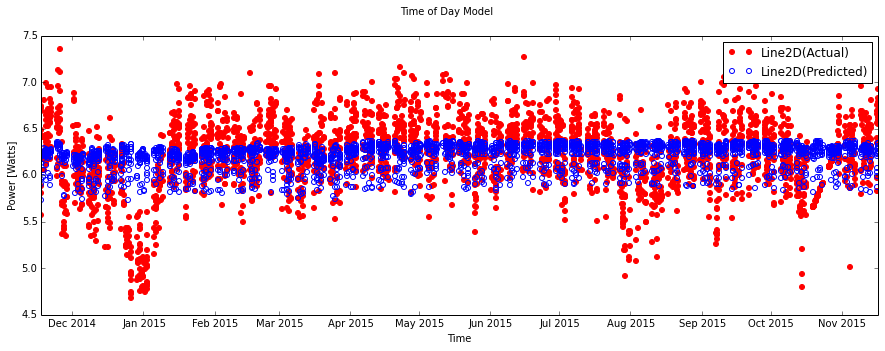

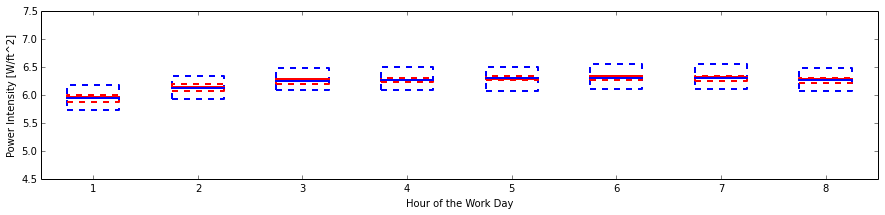

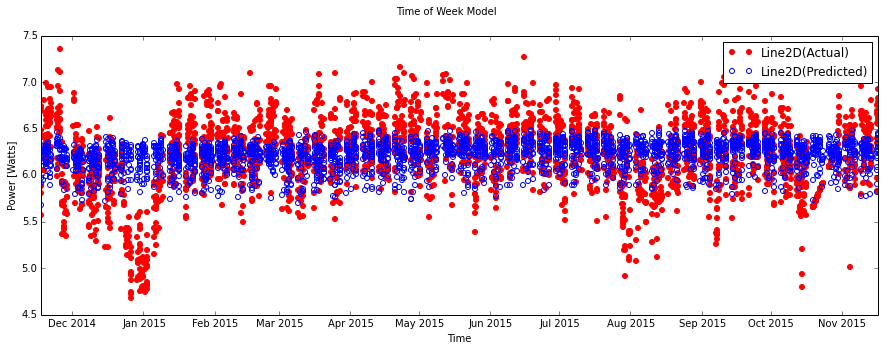

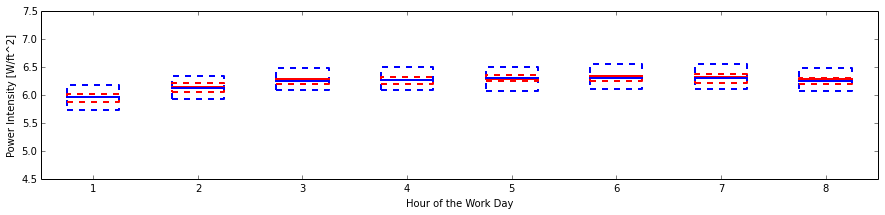

In [63]:
graph_test(actual_Roberts,predicted_Roberts_day,'day',time,data_test['Temp'])
graph_test(actual_Roberts,predicted_Roberts_week,'week',time,data_test['Temp'])


### Scaife

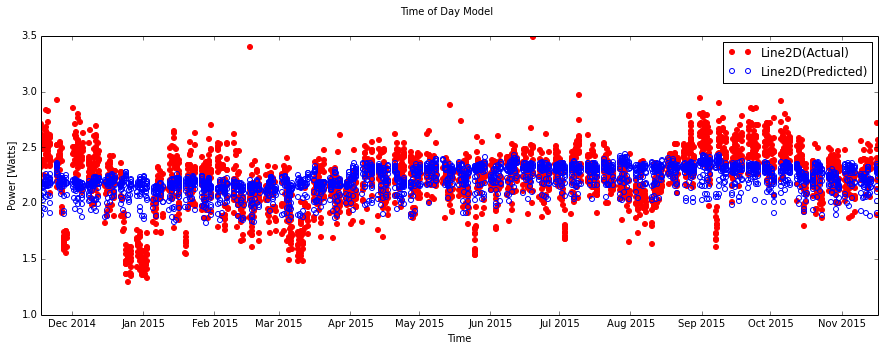

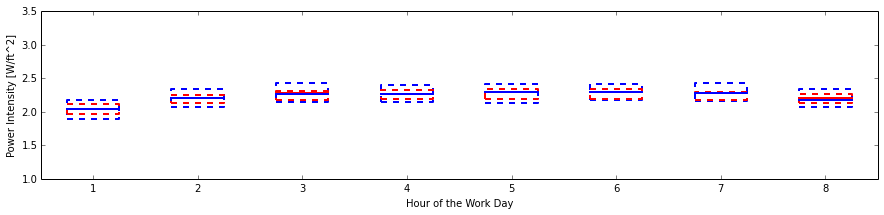

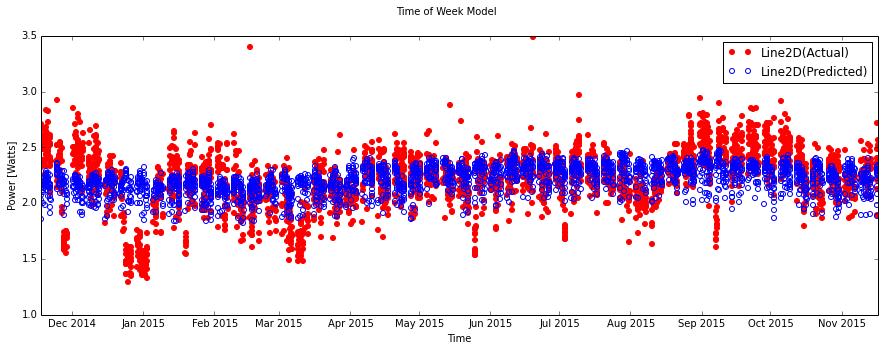

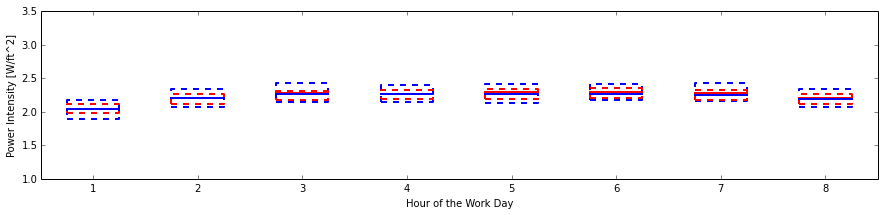

In [64]:
graph_test(actual_Scaife,predicted_Scaife_day,'day',time,data_test['Temp'])
graph_test(actual_Scaife,predicted_Scaife_week,'week',time,data_test['Temp'])

### Warner

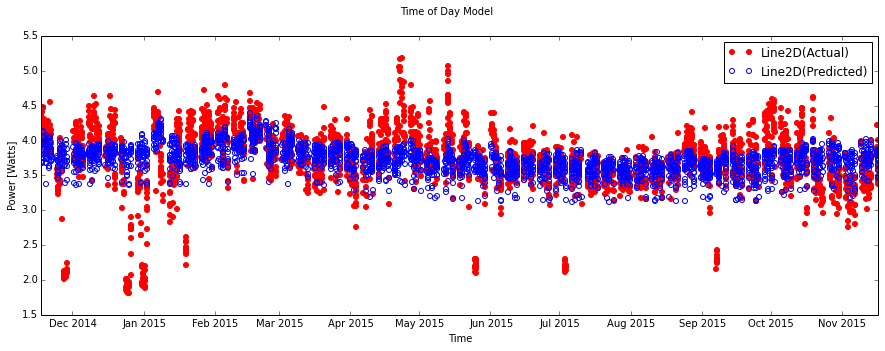

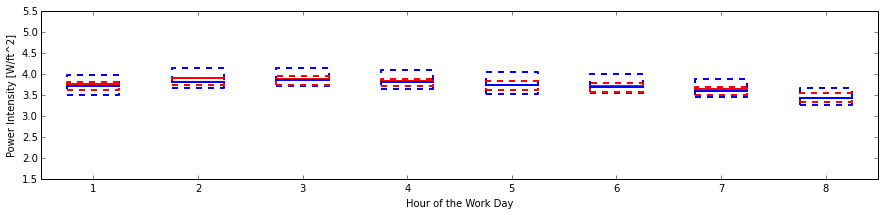

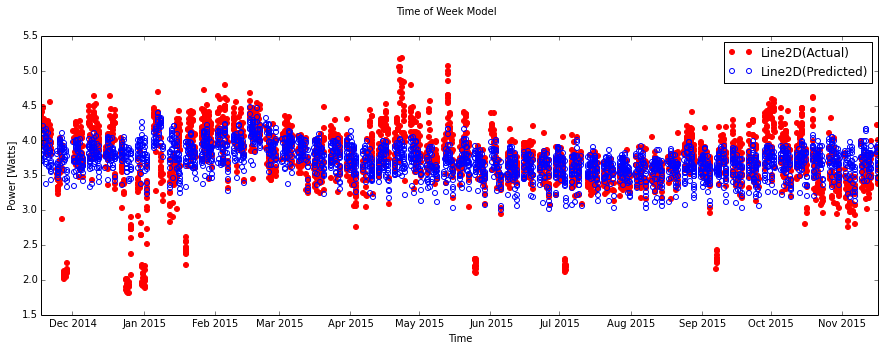

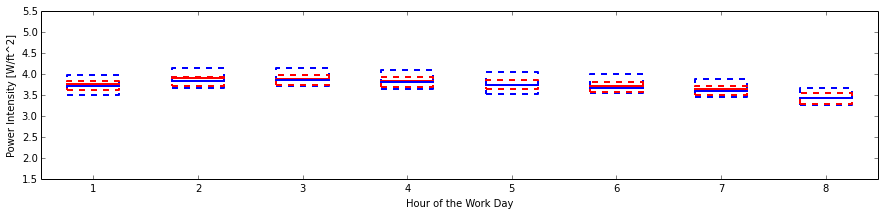

In [65]:
graph_test(actual_Warner,predicted_Warner_day,'day',time,data_test['Temp'])
graph_test(actual_Warner,predicted_Warner_week,'week',time,data_test['Temp'])

Discussion:
* The two methods graphically seem to perform the same
* The prediction shows less variance in values as compared to the actual power
* The prediction for the most part fails to follow the dips and peaks of the actual data (but you can see it doing that in some cases). Temperature is the only factor that can shift the prediction over more than a daily time frame, so the fact that there are changes shows temperature is being used in the model and is significant in some cases (the other dips and peaks are likely non temperature related). This is evident most in Warner's data. 
* The model caputres the changes over the hours of the working day reasonably well (see box plots) - although with a higher variablility than actual 
* Model seems to perform best for Warner, followed by Scaife and then Roberts. 

## Evaluating the Results Quantitatively

We can now test how well the model performed by quantifying that performance. We start by showing the $R^2$ value:
the percent of variation in the response variable that is explained by the statistical model. In our case, a linear model is used to predict the load from temperature. The $R^2$ value then is basically a measure of how close actual data points are to predicted data points. 

We find $R^2$ as:

$$R^2=1-\frac{(Y-\mathbf{X}\hat\beta)^T(Y-\mathbf{X}\hat\beta)}{Y-\bar{y})^T(Y-\bar{y})}$$

The following function calculates this quantity. 

In [40]:
### R SQUARED
def R_squared(actual,predicted):
    Y=np.vstack(actual) # get vector in correct orientation
    XBhat=np.array(predicted) 
    ybar=np.mean(Y) 
    Rsq=1-np.dot((Y-XBhat).T,(Y-XBhat))/np.dot((Y-ybar).T,(Y-ybar))
    return Rsq
print "                        R squared values "   
print "            ----------------------------------------"
print tabulate([\
    ['Roberts',R_squared(actual_Roberts,predicted_Roberts_week),\
     R_squared(actual_Roberts,predicted_Roberts_day)],\
    ['Scaife',R_squared(actual_Scaife,predicted_Scaife_week),\
     R_squared(actual_Scaife,predicted_Scaife_day)],\
    ['Warner',R_squared(actual_Warner,predicted_Warner_week),\
     R_squared(actual_Warner,predicted_Warner_day)]],\
    headers=['Building','Time of Week Model','Time of Day Model'],floatfmt=".2f")                                                      

                        R squared values 
            ----------------------------------------
Building      Time of Week Model    Time of Day Model
----------  --------------------  -------------------
Roberts                     0.11                 0.11
Scaife                      0.20                 0.20
Warner                      0.18                 0.19


We see that the percent of output variation explained by the mode is in the range 12-21%. Roberts has the lowest value while Scaife and Warner have higher values. This could be a reflection of the fact that Roberts has the research facilities which may consume power in a non predictable manner (depending on large testing appliances running, clean room HVAC systems, etc). Finally, the overall low values suggest that predicting power based on time of day or time of week and temperature may be inadequate.

Additionally, these results are important because they show that the time of week and time of day model performed virtually the same. Since the time of day model affords more data to the coefficient fitting (less indicator variables) this may be beneficial. It also makes sense since there doesn't seem to be much a change in diurnal power consumption over a week. From here on we only use the time of data indicator. 

We can check that our assumption that errors were normally distributed by plotting a histogram for each building:

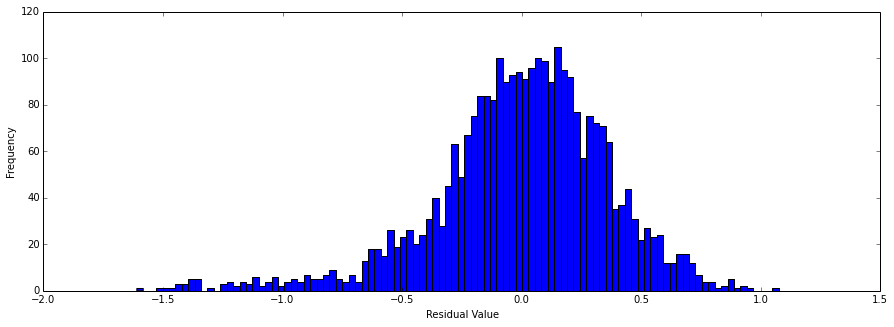

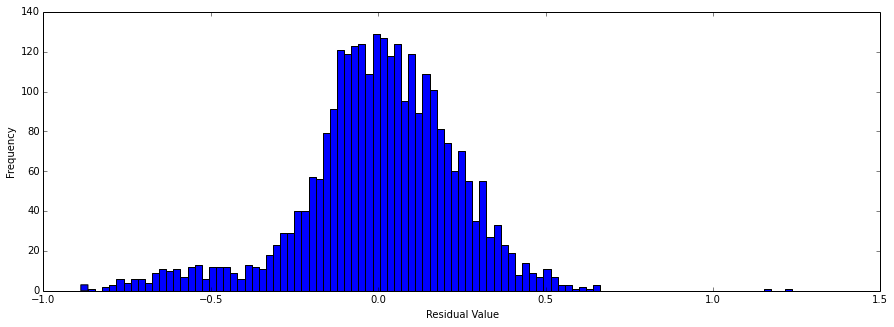

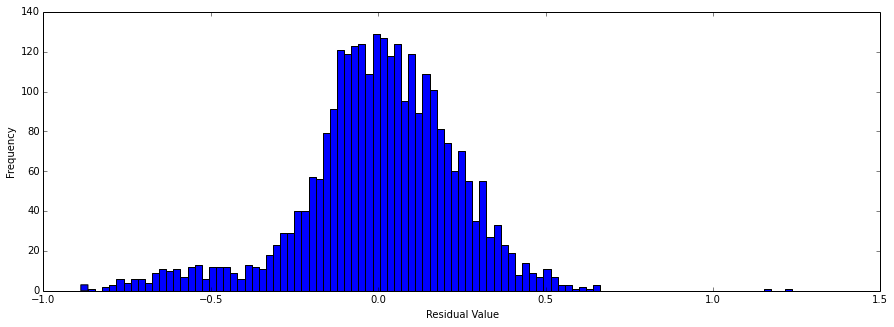

In [41]:
def PlotResiduals(actual,predicted):
    Y=np.vstack(actual) 
    XBhat=np.array(predicted) 
    residuals=(Y-XBhat)
    fig=plt.figure(figsize=(15,5))
    plt.hist(residuals,100)
    plt.ylabel('Frequency')
    plt.xlabel('Residual Value')
    return residuals
residuals_Roberts=PlotResiduals(actual_Roberts,predicted_Roberts_day)
residuals_Scaife=PlotResiduals(actual_Scaife,predicted_Scaife_day)                
residuals_Warner=PlotResiduals(actual_Scaife,predicted_Scaife_day)

The results show that the erors are indeed normally distributed about zero.

Now we create confidence intervals and do a test of significance for the coefficients in the model for each building. 

We now find a 95% confidence interval for each of the coefficients of $\hat\beta$, $\hat\beta_k$. This means we are finding a range of values such that 95% of the time, the true value of $\beta_k$ will fall in this range. The confidence interval is found mathematically as:

$$\hat\beta_k \pm ts\{\hat\beta_K\}$$

$s\{\hat\beta_K\}$ is found as the square root of $s^2\{\hat\beta_K\}$ which is the kth diagonal element of $s^2\{\hat\beta\}_{pxp}$ where $p$ is the number of explanatory (independent) variables - in this case the number of times of day plus the number of temperature bounds.
$$s^2\{\hat\beta_K\}=MSEx(X^TX)^{-1}$$
$$MSE=\frac{SSE}{df}$$
$$SSE=\epsilon\epsilon^T$$
$$\epsilon=Y-X\hat\beta$$

Then to find the confidence interval the only remaining variable to specify is $t$:
$$t=t_{n-p}(0.975)$$

Where $n$ is the number of data points or rows of temperature-time-power data.

We also wish to test if the null hypothesis $H_0: \hat\beta_k=0$ can be rejected at different levels of confidence $\alpha$. Essentially, we are trying to find out if the regression coefficients are significant - if our model outputs depend on our model inputs. We can do this by finding a probability associated with a normalized $t^*$ statistic on a t distribution:
$$t^*=\frac{\hat\beta_K}{s\{\hat\beta_K\}}$$

The code below calculates and prints out the confidence intervals and  p values (probabilities) for the time of week indicator coefficients as well as  each piecewise temperature coefficient.

In [69]:
def CI(residuals,X,Bh):
    SSE=np.dot(residuals.T,residuals)[0][0]
    n=len(residuals)
    T_bound=create_bounds(data_test['Temp'],10)
    p=len(X[0])
    df=n-p
    MSE=SSE/df
    s_sq=np.matrix(np.multiply(MSE,np.linalg.inv(X.T*X)))
    s_sq_beta_K=np.vstack(np.diagonal(s_sq))
    from scipy.stats import t as students_t
    t=students_t.isf((1-0.95)/2,df)
    f=lambda x: x*t
    tbeta=np.vstack(map(f,s_sq_beta_K))
    CIs=np.concatenate(((Bh-tbeta),Bh),axis=1)
    CIs=np.concatenate((CIs,(tbeta+Bh)),axis=1)
    s_betaK=np.sqrt(s_sq_beta_K)
    t_stars=np.divide(Bh,s_betaK)
    f= lambda x: ((students_t.sf(x,df))/2)
    f=np.vectorize(f)
    p_values=f(t_stars)
    return np.concatenate((CIs,p_values),axis=1)

CIs_Roberts=CI(residuals_Roberts,X_test_day,Bh_Roberts_day)
CIs_Scaife=CI(residuals_Scaife,X_test_day,Bh_Scaife_day)
CIs_Warner=CI(residuals_Warner,X_test_day,Bh_Warner_day)
print "Beta CIs and P Value: [Lower Beta_Value Upper P-Value]\n\n"
print len(CIs_Roberts)
np.set_printoptions(precision=3,suppress=True)
print "ROBERTS"
print "CIs for time of day indicator coefficients"
print CIs_Roberts[0:-10]

print "SCAIFE"
print "CIs for time of day indicator coefficients "
print CIs_Scaife[0:-10]

print "WARNER"
print "CIs for time of day indicator coefficients"
print CIs_Warner[0:-10]


Beta CIs and P Value: [Lower Beta_Value Upper P-Value]


58
ROBERTS
CIs for time of day indicator coefficients
[[ 5.956  6.012  6.067  0.   ]
 [ 5.943  5.996  6.049  0.   ]
 [ 6.011  6.067  6.123  0.   ]
 [ 6.059  6.115  6.172  0.   ]
 [ 6.08   6.137  6.194  0.   ]
 [ 6.111  6.166  6.22   0.   ]
 [ 6.142  6.198  6.254  0.   ]
 [ 6.164  6.22   6.275  0.   ]
 [ 6.165  6.22   6.276  0.   ]
 [ 6.263  6.321  6.378  0.   ]
 [ 6.286  6.342  6.398  0.   ]
 [ 6.288  6.347  6.405  0.   ]
 [ 6.278  6.334  6.39   0.   ]
 [ 6.306  6.362  6.418  0.   ]
 [ 6.349  6.406  6.463  0.   ]
 [ 6.318  6.375  6.432  0.   ]
 [ 6.354  6.411  6.468  0.   ]
 [ 6.321  6.378  6.435  0.   ]
 [ 6.374  6.431  6.487  0.   ]
 [ 6.35   6.407  6.464  0.   ]
 [ 6.326  6.383  6.441  0.   ]
 [ 6.358  6.416  6.473  0.   ]
 [ 6.347  6.403  6.459  0.   ]
 [ 6.324  6.381  6.439  0.   ]
 [ 6.37   6.428  6.486  0.   ]
 [ 6.401  6.458  6.515  0.   ]
 [ 6.379  6.436  6.493  0.   ]
 [ 6.362  6.42   6.477  0.   ]
 [ 6.366  6.424  6.48

We see that there is no non zero probability that any of the time of day coefficients are zero - this means these are significant in the model. Below we look closer at the temperature coefficients:

In [43]:
p_R=[]
for row in np.array(CIs_Roberts[-10:]):
    p_R.append(row[3])
p_S=[]
for row in np.array(CIs_Scaife[-10:]):
    p_S.append(row[3])
p_W=[]
for row in np.array(CIs_Warner[-10:]):
    p_W.append(row[3])
    

print '        P values for temperature coefficients'
print '--------------------------------------------------'
print tabulate([['0-10 F',p_R[0],p_S[0],p_W[0]],['10-20 F',p_R[1],p_S[1],p_W[1]],\
               ['20-30 F',p_R[2],p_S[2],p_W[2]],['30-40 F',p_R[3],p_S[3],p_W[3]],\
                ['40-50 F',p_R[4],p_S[4],p_W[4]],['50-60 F',p_R[5],p_S[5],p_W[5]],\
                ['60-70 F',p_R[6],p_S[6],p_W[6]],['70-80 F',p_R[7],p_S[7],p_W[7]],\
               ['80-90 F',p_R[8],p_S[8],p_W[8]],['90-100 F',p_R[9],p_S[9],p_W[9]]],\
               headers=['Temperature Range','Roberts','Scaife','Warner'],floatfmt=".2f")       

        P values for temperature coefficients
--------------------------------------------------
Temperature Range      Roberts    Scaife    Warner
-------------------  ---------  --------  --------
0-10 F                    0.39      0.48      0.44
10-20 F                   0.27      0.21      0.50
20-30 F                   0.33      0.00      0.50
30-40 F                   0.48      0.49      0.43
40-50 F                   0.00      0.10      0.00
50-60 F                   0.40      0.00      0.50
60-70 F                   0.02      0.00      0.21
70-80 F                   0.32      0.43      0.50
80-90 F                   0.33      0.00      0.01
90-100 F                  0.30      0.17      0.31


At 95% confidence level:
* Roberts - 2/10 beta coefficients may be significant for relating temp to power
* Scaife - 4/10 beta coefficients may be significant 
* Warner - 2/10 may be significant

In all, we see that between 60 and 80% of the temperature coefficients for each building are not significant in the model.

## Applying to all Hours of the Day

## Taking a Data Subset: weekdays

At this point we want to see if the same model can be applied to all hours of the 24 hour day instead of just business hours. The assumption is that the response of power to temperature does not change depending on the occupancy level of the building. While this assumption seems far fetched, we have seen that the power was mostly a function of the time of day and not clearly related to temperature. Thus, this is a natural extension of that model to look at the way time of day is related to power at all hours.

In [44]:
data_24hrs=np.take(data,weekday_indices)

In [45]:
### 10 MINUTE DAILY RESOLUTION VERSION
def DesignMatrix_24day(data_subset):
    bounds=create_bounds(data_subset['Temp'],10)
    temps=data_subset['Temp']
    Tc_matrix=Tc(temps,bounds)
    rows=[]
    for i,time in enumerate(data_subset['Time']):
        minute=time.minute
        hour=time.hour
        row=[0]*(24*6)
        index=((hour)*6+minute/10)
        row[index]=1
        row=row+list(Tc_matrix[i])
        rows.append(row)
    # now we return that (as a matrix)
    return np.matrix(rows)

In [46]:
def Split24Data(data):
    random_indices=random.sample(xrange(0,len(data)),len(data))
    train_indices=random_indices[:len(random_indices)/2]
    test_indices=random_indices[len(random_indices)/2:]
    data_train=np.take(data,train_indices)
    data_test=np.take(data,test_indices[:-3300])
    return (np.sort(data_train,order='Time'),np.sort(data_test,order='Time'))
data_24train=Split24Data(data_24hrs)[0]
data_24test=Split24Data(data_24hrs)[1]

In [47]:
X_train_24day=DesignMatrix_24day(data_24train)
X_test_24day=DesignMatrix_24day(data_24test)
Bh_Roberts_24day=beta_hat(X_train_24day,data_24train['Roberts'])
Bh_Scaife_24day=beta_hat(X_train_24day,data_24train['Scaife'])
Bh_Warner_24day=beta_hat(X_train_24day,data_24train['Warner'])

In [48]:
# generate predicted power usage
predicted_Roberts_24day=np.dot(X_test_24day,Bh_Roberts_24day)
predicted_Scaife_24day=np.dot(X_test_24day,Bh_Scaife_24day)
predicted_Warner_24day=np.dot(X_test_24day,Bh_Warner_24day)
# get actual power usage
actual_24Roberts=data_24test['Roberts']
actual_24Scaife=data_24test['Scaife']
actual_24Warner=data_24test['Warner']
time24=data_24test['Time']

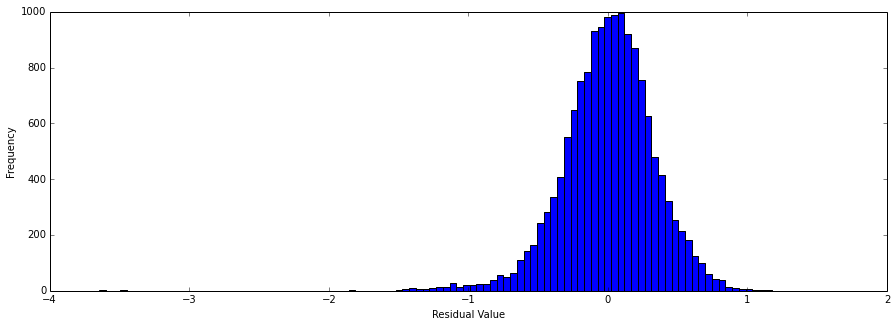

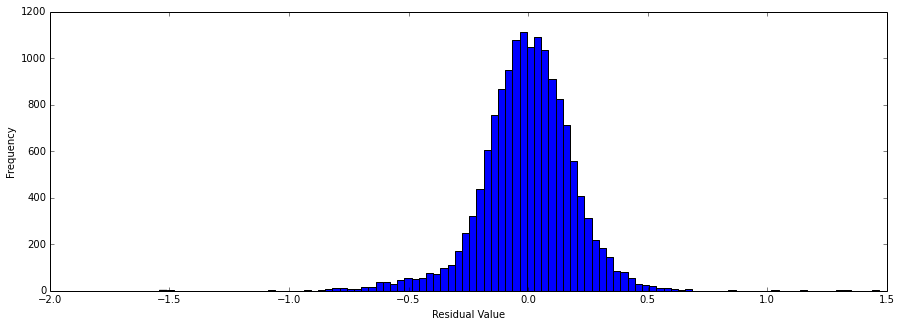

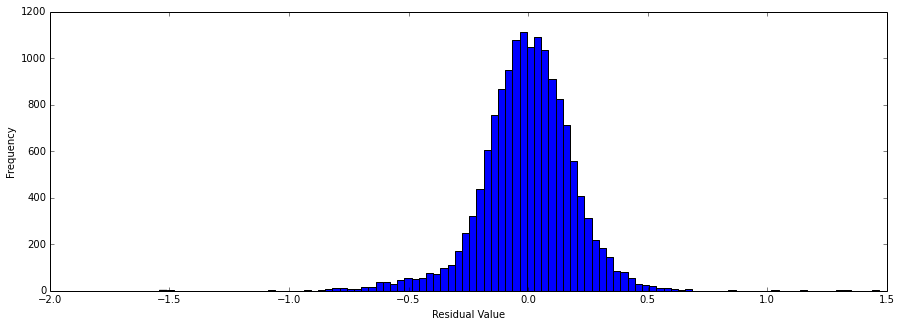

In [61]:
residuals_24Roberts=PlotResiduals(actual_24Roberts,predicted_Roberts_24day);
residuals_24Scaife=PlotResiduals(actual_24Scaife,predicted_Scaife_24day);            
residuals_24Warner=PlotResiduals(actual_24Scaife,predicted_Scaife_24day);

In [53]:
# function for plotting results and graphical evaluation of model
def graph_24test(actual,predicted,model_name,time,temps):
    fig=plt.figure(figsize=(15,5))
    if model_name=='day':
        fig.suptitle("Time of Day Model")
    else:
        fig.suptitle("Time of Week Model")
    actuals, =plt.plot(time[0:],actual[0:], label='Actual',\
                          marker='o',markeredgewidth=1,markeredgecolor='red',\
                          markerfacecolor="red",linewidth=0,markersize=5)
    predicteds, =plt.plot(time[0:],predicted[0:], label='Predicted',marker='o',\
                       markerfacecolor="None",markeredgewidth=1,\
                       markeredgecolor='blue',linewidth=0,markersize=5)
    plt.xlabel('Time')
    plt.ylabel('Power [Watts]')

    plt.legend((actuals,predicteds))
    
    fig=plt.figure(figsize=(15,3));
    one=plt.boxplot([[actual[np.where(np.array([t.hour for t in time])==i)[0]]] \
                     for i in range(24)],patch_artist=True);
    two=plt.boxplot([[predicted[np.where(np.array([t.hour for t in time])==i)[0]]]\
                     for i in range(24)],patch_artist=True);
  
    plt.ylabel('Power Intensity [W/ft^2]');
    plt.xlabel("Hour of the Day");
    
   
    ## change outline color, fill color and linewidth of the boxes
    for box in one['boxes']:
        # change outline color
        box.set( color='blue', linewidth=2,linestyle='dashed')
        box.set( facecolor = 'none' ,alpha=1)
    ## change color and linewidth of the whiskers
    for whisker in one['whiskers']:
        whisker.set(color='red', linewidth=0)

    ## change color and linewidth of the caps
    for cap in one['caps']:
        cap.set(color='red', linewidth=0)

    ## change color and linewidth of the medians
    for median in one['medians']:
        median.set(color='red', linewidth=2)

    ## change the style of fliers and their fill
    for flier in one['fliers']:
        flier.set(marker=None, color='red', alpha=0.5)
                     
    ##########################
                     
    ## change outline color, fill color and linewidth of the boxes
    for box in two['boxes']:
        # change outline color
        box.set( color='red', linewidth=2,linestyle='dashed')
        box.set( facecolor = 'none' ,alpha=1)
    ## change color and linewidth of the whiskers
    for whisker in two['whiskers']:
        whisker.set(color='blue', linewidth=0)

    ## change color and linewidth of the caps
    for cap in two['caps']:
        cap.set(color='blue', linewidth=0)

    ## change color and linewidth of the medians
    for median in two['medians']:
        median.set(color='blue', linewidth=2)

    ## change the style of fliers and their fill
    for flier in two['fliers']:
        flier.set(marker=None, color='#e7298a', alpha=0.5)

### Roberts

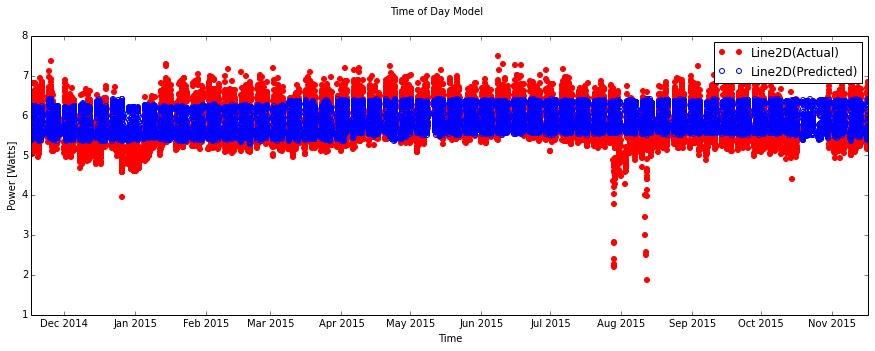

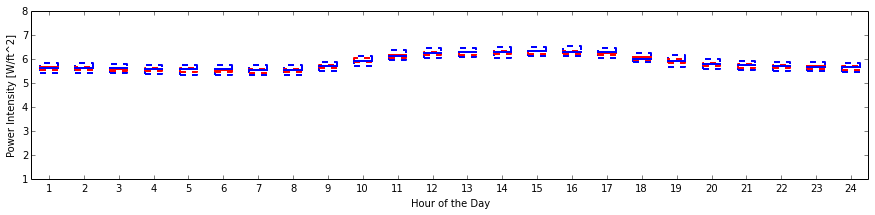

In [54]:
graph_24test(actual_24Roberts,predicted_Roberts_24day,'day',time24,data_24test['Temp'])


### Scaife

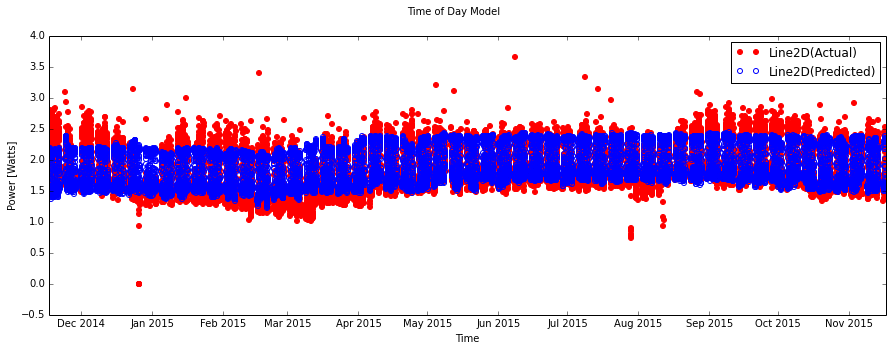

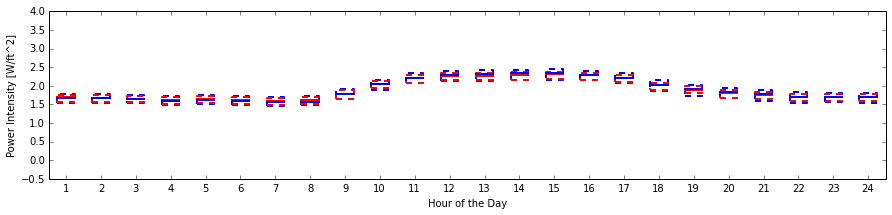

In [55]:
graph_24test(actual_24Scaife,predicted_Scaife_24day,'day',time24,data_24test['Temp'])


### Warner

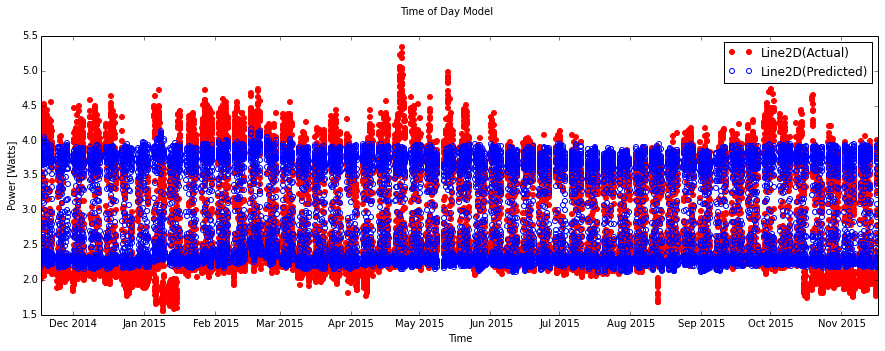

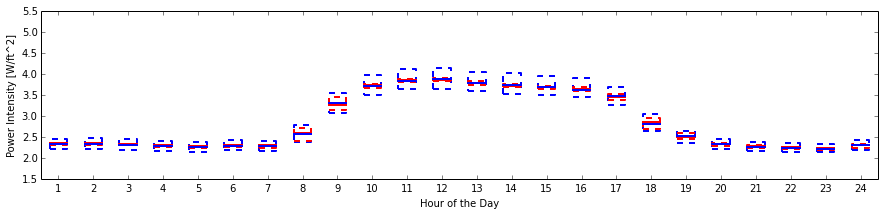

In [57]:
graph_24test(actual_24Warner,predicted_Warner_24day,'day',time24,data_24test['Temp'])


The prediction with respect to time of day is much more clear in these plots, especially for warner. Let's see if the quantitative reuslts change. 

In [58]:

print "                        R squared values "   
print "            ----------------------------------------"
print tabulate([\
    ['Roberts',R_squared(actual_24Roberts,predicted_Roberts_24day)],\
    ['Scaife',R_squared(actual_24Scaife,predicted_Scaife_24day)],\
    ['Warner',R_squared(actual_24Warner,predicted_Warner_24day)]],\
    headers=['Building','Time of Day Model'],floatfmt=".2f")                                                      

                        R squared values 
            ----------------------------------------
Building      Time of Day Model
----------  -------------------
Roberts                    0.43
Scaife                     0.68
Warner                     0.81


Since we are effectively looking at a data set with more variation day to day, and since with considering all hours of the day that variation can be explained better, is seems logicla that the R squared values for this model would be higher. 

In [73]:
CIs_24Roberts=CI(residuals_24Roberts,X_test_24day,Bh_Roberts_24day)
CIs_24Scaife=CI(residuals_24Scaife,X_test_24day,Bh_Scaife_24day)
CIs_24Warner=CI(residuals_24Warner,X_test_24day,Bh_Warner_24day)
print "Beta CIs: [Lower Beta_Value Upper]\n\n"

np.set_printoptions(precision=3,suppress=True)
print "ROBERTS"
print "CIs for time of day indicator coefficients : "
print CIs_24Roberts[0:-10]

print "SCAIFE"
print "CIs for time of day indicator coefficients : "
print CIs_24Scaife[0:-10]

print "WARNER"
print "CIs for time of day indicator coefficients : "
print CIs_24Warner[0:-10]


Beta CIs: [Lower Beta_Value Upper]


ROBERTS
CIs for time of day indicator coefficients : 
[[ 4.07   4.624  5.178  0.   ]
 [ 3.995  4.549  5.102  0.   ]
 [ 4.055  4.611  5.167  0.   ]
 [ 4.083  4.638  5.192  0.   ]
 [ 4.076  4.631  5.187  0.   ]
 [ 4.076  4.631  5.187  0.   ]
 [ 4.03   4.585  5.14   0.   ]
 [ 4.077  4.632  5.187  0.   ]
 [ 4.052  4.607  5.162  0.   ]
 [ 4.08   4.635  5.189  0.   ]
 [ 4.037  4.593  5.148  0.   ]
 [ 4.051  4.606  5.16   0.   ]
 [ 4.08   4.636  5.191  0.   ]
 [ 4.064  4.62   5.176  0.   ]
 [ 4.013  4.568  5.123  0.   ]
 [ 3.991  4.546  5.102  0.   ]
 [ 4.031  4.586  5.141  0.   ]
 [ 4.016  4.571  5.127  0.   ]
 [ 4.007  4.562  5.117  0.   ]
 [ 4.048  4.602  5.156  0.   ]
 [ 4.033  4.586  5.14   0.   ]
 [ 4.018  4.571  5.124  0.   ]
 [ 3.987  4.54   5.094  0.   ]
 [ 3.987  4.54   5.093  0.   ]
 [ 4.011  4.565  5.119  0.   ]
 [ 4.004  4.558  5.113  0.   ]
 [ 3.975  4.53   5.085  0.   ]
 [ 4.021  4.574  5.127  0.   ]
 [ 4.026  4.58   5.135  0.   ]
 [ 4.017  

We see that for Richards and Warner the time of day coefficients are significant for all hours of the day. For Scaife, the coefficients are only significant during the business hours of the day. This suggests temperature is the predictor for this building during off business hours.

In [60]:
p_24R=[]
for row in np.array(CIs_24Roberts[-10:]):
    p_24R.append(row[3])
p_24S=[]
for row in np.array(CIs_24Scaife[-10:]):
    p_24S.append(row[3])
p_24W=[]
for row in np.array(CIs_24Warner[-10:]):
    p_24W.append(row[3])
    

print '        P values for temperature coefficients'
print '--------------------------------------------------'
print tabulate([['0-10 F',p_24R[0],p_24S[0],p_24W[0]],['10-20 F',p_24R[1],p_24S[1],p_24W[1]],\
               ['20-30 F',p_24R[2],p_24S[2],p_24W[2]],['30-40 F',p_24R[3],p_24S[3],p_24W[3]],\
                ['40-50 F',p_24R[4],p_24S[4],p_24W[4]],['50-60 F',p_24R[5],p_24S[5],p_24W[5]],\
                ['60-70 F',p_24R[6],p_24S[6],p_24W[6]],['70-80 F',p_24R[7],p_24S[7],p_24W[7]],\
               ['80-90 F',p_24R[8],p_24S[8],p_24W[8]],['90-100 F',p_24R[9],p_24S[9],p_24W[9]]],\
               headers=['Temperature Range','Roberts','Scaife','Warner'],floatfmt=".2f")       

        P values for temperature coefficients
--------------------------------------------------
Temperature Range      Roberts    Scaife    Warner
-------------------  ---------  --------  --------
0-10 F                    0.02      0.00      0.09
10-20 F                   0.35      0.50      0.50
20-30 F                   0.21      0.00      0.50
30-40 F                   0.50      0.00      0.50
40-50 F                   0.17      0.10      0.50
50-60 F                   0.00      0.00      0.00
60-70 F                   0.48      0.00      0.01
70-80 F                   0.05      0.00      0.45
80-90 F                   0.38      0.48      0.50
90-100 F                  0.47      0.00      0.00



For temperautre, for several of the coefficients there is no relation between temperature and power - ie the probability that the coefficient is not zero is low. Specfically:
* Roberts - 7/10 temperature ranges have high p of beta zero, 3/10 temperature ranges have low p of beta being zero (there could be a relation between temperature and power). 
* Scaife - 3/10 temperature ranges - beta is probably zero. 7/10 - beta likely not zero. So, Scaife, among the 3 buildings, seems to react the most to temperature changes in terms of power use. This makes sense looking at the coefficients for time of day for Scaife which are only significant during business hours.
* Warner - 7/10, 3/10. Like Roberts. 

So in this model, we find that the model can be extended to the full range of hours in a day without hurting performance as compared to when the model is applied during only business hours. The model could be improved perhaps by dividing the data between occupied and not occupied so that different regression coefficients can be developed. It is unclear at this time if this would aid in performance of the model. 